In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
%matplotlib inline

from model import NN

from torch.optim.lr_scheduler import StepLR


#from train import training_routine_uniform
from functions import uniform_circle_loss_function_method2
from train import training_routine
from train import testing_routine

from visuals import plot_transformed_grid_and_density, compute_uniform_circle_density

from pathlib import Path

In [2]:
def save_model(model, data = 'Ellipse', checkpoint_number=1):
    checkpoints_dir= './checkpoints/'
    save_path = Path(checkpoints_dir) / Path("{}/experiment{}.pth".format(data, checkpoint_number))
    save_path.parent.mkdir(parents=True, exist_ok=True)
    torch.save(model.state_dict(), save_path)
    print("Saved checkpoint:", save_path)
    
def load_model(num_coupling_layers=3,layer_size=2, split_size_x1=1, nn_size=(1,100), path=f"./checkpoints/Ellipse/experiment{1}.pth"):
    model = NN(num_coupling_layers, layer_size, split_size_x1, nn_size).to(device)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model


In [3]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [4]:
def generate_ellipse(max_num = 10000, scale=(0.5,0.2)):
    data = (torch.rand((max_num,2))-0.5)*2
    dist = torch.sum(torch.square(data),axis=1)
    data = data[torch.where(dist <= 1)]
    data *= torch.tensor(scale)
    return data

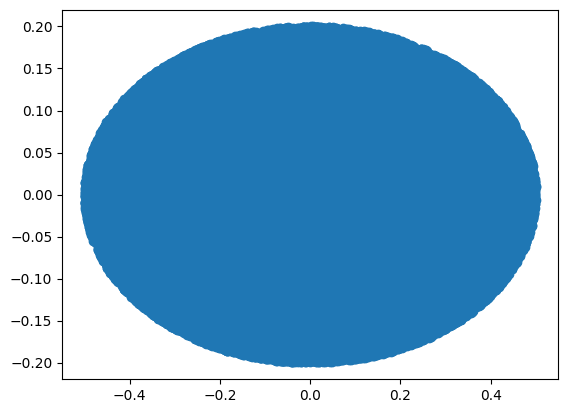

In [5]:
train_loader = generate_ellipse(max_num=100000, scale=(0.5,0.2))
test_loader = generate_ellipse(max_num=10000, scale=(0.5,0.2))
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

# Training with uniform density

In [6]:
torch.manual_seed(0)

model = NN(num_coupling_layers=3,layer_size=2, split_size_x1=1, nn_size=(1,100)).to(device)
model

NN(
  (layers): ModuleList(
    (0-2): 3 x CouplingLayer(
      (t_net): ModuleList(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): Linear(in_features=100, out_features=100, bias=True)
        (2): Linear(in_features=100, out_features=1, bias=True)
      )
      (s_net): ModuleList(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): Linear(in_features=100, out_features=100, bias=True)
        (2): Linear(in_features=100, out_features=1, bias=True)
      )
      (activation): ReLU()
    )
  )
)

In [7]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
num_epoch = 20

In [9]:
%%time

batch_size = 1024 # Batch size must be very large! otherwise density gets concentrated if next data point is not in reach
for epoch in range(num_epoch):
    training_routine(model, device, train_loader, optimizer, epoch, batch_size, uniform_circle_loss_function_method2) 
    print(testing_routine(model, device, test_loader, batch_size, uniform_circle_loss_function_method2))

tensor(-2761.4468, device='cuda:0')
tensor(-10442.8808, device='cuda:0')
tensor(-16861.4170, device='cuda:0')
tensor(-16919.9459, device='cuda:0')
tensor(-16926.1474, device='cuda:0')
tensor(-16928.9137, device='cuda:0')
tensor(-16930.3072, device='cuda:0')
tensor(-16931.0964, device='cuda:0')
tensor(-16931.6058, device='cuda:0')
tensor(-16931.9788, device='cuda:0')
tensor(-16932.2764, device='cuda:0')
tensor(-16932.5282, device='cuda:0')
tensor(-16932.7460, device='cuda:0')
tensor(-16932.9403, device='cuda:0')
tensor(-16933.1138, device='cuda:0')
tensor(-16933.2711, device='cuda:0')
tensor(-16933.4152, device='cuda:0')
tensor(-16933.5479, device='cuda:0')
tensor(-16933.6700, device='cuda:0')
tensor(-16933.7841, device='cuda:0')
CPU times: total: 25.1 s
Wall time: 25.5 s


0

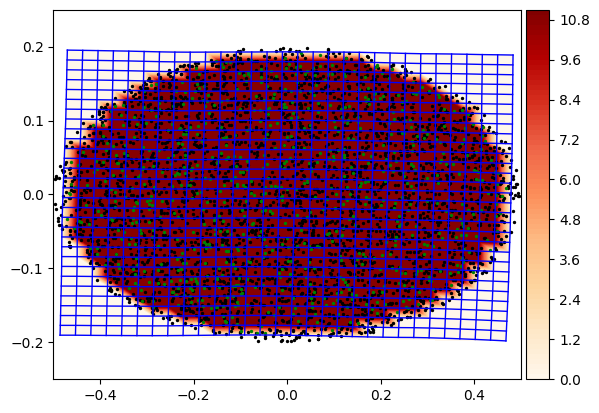

In [14]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.25*scale,0.25*scale),
                                density_function=compute_uniform_circle_density)

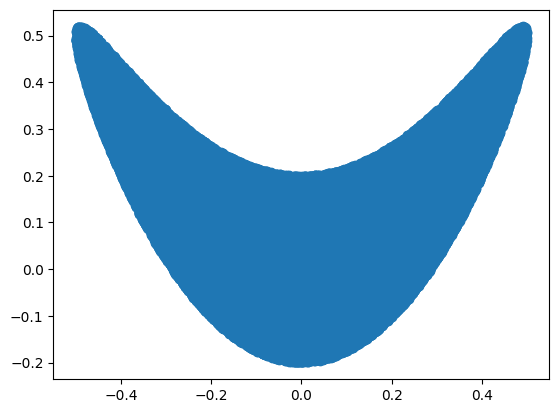

In [5]:
def generate_banana(n=100000):
    train_loader = generate_ellipse(n)
    train_loader[:, 1] = train_loader[:,1] + 2*train_loader[:,0]**2
    return train_loader
train_loader = generate_banana()
test_loader = generate_banana(10000)
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

In [6]:
model_banana = NN(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200)).to(device)

In [10]:
optimizer = torch.optim.SGD(model_banana.parameters(), lr=0.1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)
num_epoch = 20

In [11]:
%%time

batch_size = 128 # Batch size must be very large! otherwise density gets concentrated if next data point is not in reach
for epoch in range(num_epoch):
    training_routine(model_banana, device, train_loader, optimizer, epoch, batch_size, uniform_circle_loss_function_method2) 
    print(testing_routine(model_banana, device, test_loader, batch_size, uniform_circle_loss_function_method2))
    scheduler.step()

100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:21<00:00, 28.84it/s]


tensor(-12812.5492, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:22<00:00, 26.94it/s]


tensor(-17453.3541, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:26<00:00, 23.12it/s]


tensor(-15934.1293, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:30<00:00, 20.08it/s]


tensor(-14331.9188, device='cuda:0')


100%|████████████████████████████████████████████████████████████████████████████████| 613/613 [00:41<00:00, 14.85it/s]


tensor(-17119.7590, device='cuda:0')


 14%|███████████▎                                                                     | 86/613 [00:06<00:41, 12.70it/s]


KeyboardInterrupt: 

D:\master-thesis\acl\visuals.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

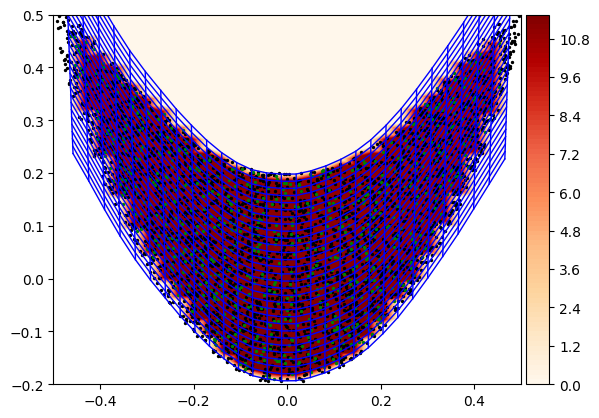

In [16]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_banana, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.2*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

0

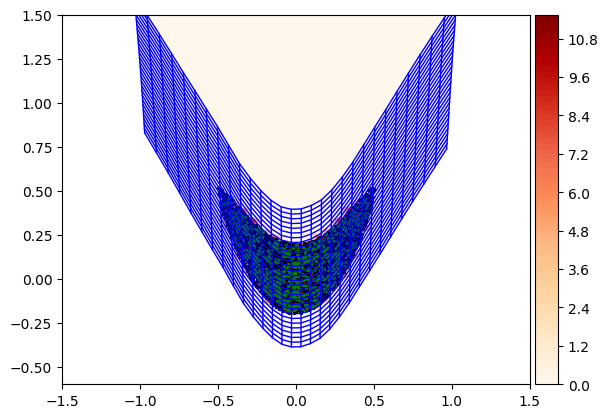

In [17]:
scale=3
factor=2

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_banana, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-0.5*scale,0.5*scale), y_lim=(-0.2*scale,0.5*scale),
                                density_function=compute_uniform_circle_density)

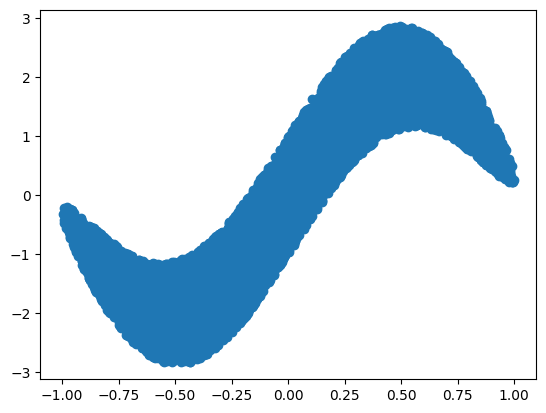

In [190]:
def generate_wave(n=10000):
    train_loader = generate_ellipse(n, (1,1))
    train_loader[:, 1] = train_loader[:,1] + 2*torch.sin(3*train_loader[:,0])
    return train_loader
train_loader = generate_wave()
test_loader = generate_wave(1000)
plt.scatter(np.array(train_loader)[:,0], np.array(train_loader)[:,1])

In [249]:
#model_wave=load_model(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200), path=f"./checkpoints/Wave/experiment{1}.pth")
#model_wave=load_model(num_coupling_layers=8,layer_size=2, split_size_x1=1, nn_size=(1,200), path=f"./checkpoints/Wave/experiment{2}.pth")
#model_wave=load_model(num_coupling_layers=10,layer_size=2, split_size_x1=1, nn_size=(1,200), path=f"./checkpoints/Wave/experiment{3}.pth")
model_wave_2 =load_model(num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,50), path=f"./checkpoints/Wave/experiment{6}.pth")
# model_wave_2=load_model(num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,50), path=f"./checkpoints/Wave/experiment{5}.pth")

In [160]:
model_wave = NN(num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,50)).to(device)

In [216]:
optimizer = torch.optim.SGD(model_wave.parameters(), lr=0.06, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.99)
num_epoch = 20

In [212]:
scheduler.get_lr()[0]*1.06

0.060292809781304725

In [217]:
%%time
num_epoch = 5
batch_size = 128  # Batch size must be very large! otherwise density gets concentrated if next data point is not in reach
for epoch in range(num_epoch):
    training_routine(model_wave, device, train_loader, optimizer, epoch, batch_size, uniform_circle_loss_function_method2) 
    print(testing_routine(model_wave, device, test_loader, batch_size, uniform_circle_loss_function_method2))
    scheduler.step()

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:29<00:00,  2.07it/s]


tensor(72.2460, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:29<00:00,  2.06it/s]


tensor(83.6223, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:30<00:00,  2.03it/s]


tensor(77.0702, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:38<00:00,  1.57it/s]


tensor(74.1103, device='cuda:0')


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:32<00:00,  1.90it/s]


tensor(56.6739, device='cuda:0')
CPU times: total: 2min 45s
Wall time: 2min 46s


D:\master-thesis\acl\visuals.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

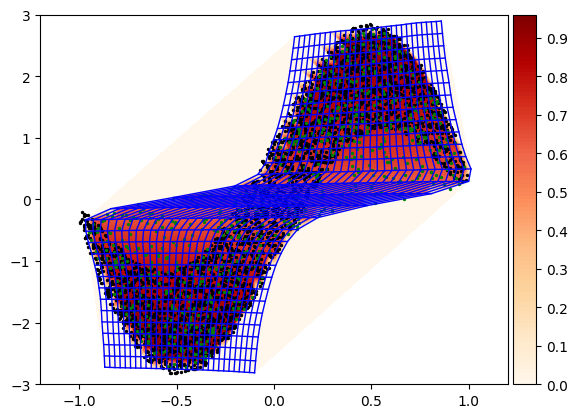

In [18]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [11]:
save_model(model_wave, data='Wave', checkpoint_number = 2)

Saved checkpoint: checkpoints\Wave\experiment2.pth


D:\master-thesis\acl\visuals.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, device=device), reverse=True)


0

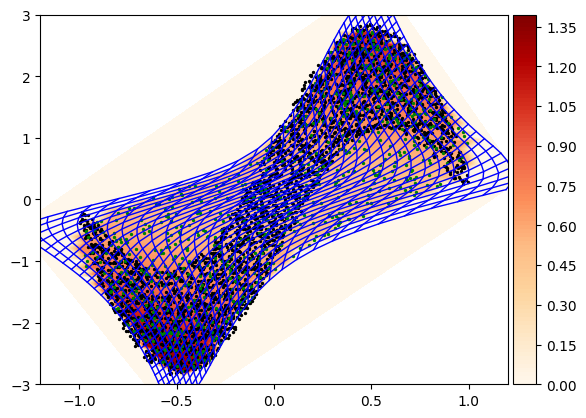

In [13]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

0

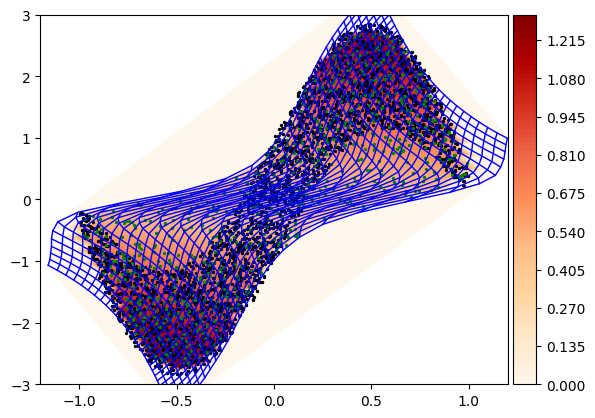

In [106]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [81]:
save_model(model_wave, data='Wave', checkpoint_number = 3)

Saved checkpoint: checkpoints\Wave\experiment3.pth


0

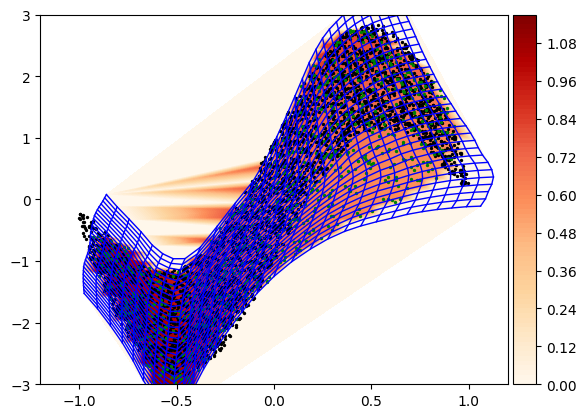

In [170]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [171]:
save_model(model_wave, data='Wave', checkpoint_number = 5)

Saved checkpoint: checkpoints\Wave\experiment5.pth


0

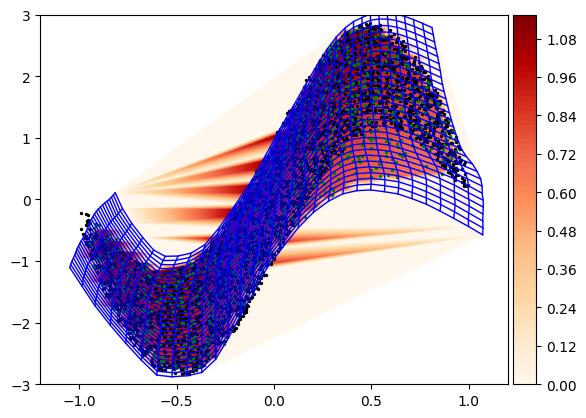

In [194]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

0

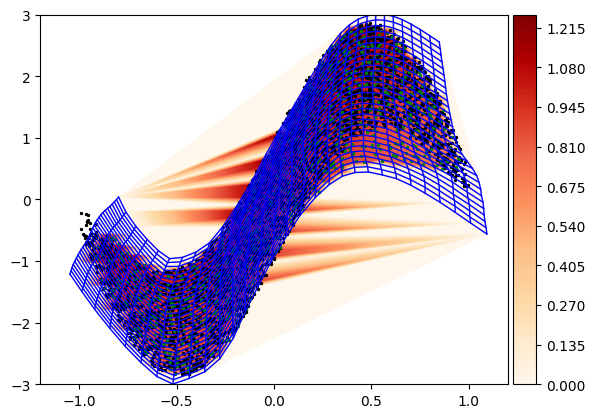

In [218]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [219]:
save_model(model_wave, data='Wave', checkpoint_number = 6)

Saved checkpoint: checkpoints\Wave\experiment6.pth


0

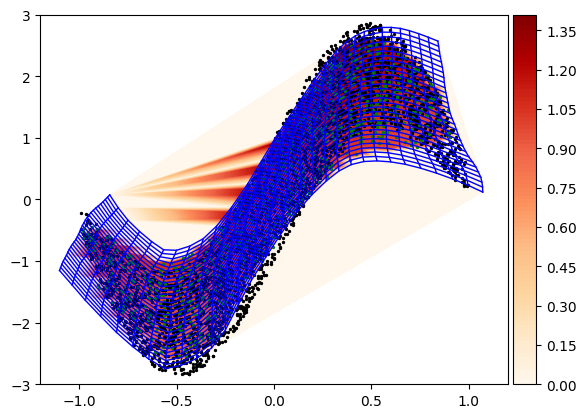

In [215]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [256]:
save_model(model_wave, data='Wave', checkpoint_number = 7)

Saved checkpoint: checkpoints\Wave\experiment7.pth


In [287]:
model_wave_2 =load_model(num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,50), path=f"./checkpoints/Wave/experiment{7}.pth")

In [266]:
model_wave(sampling_data.to(device), reverse=True)

tensor([[-0.3596, -2.5988],
        [-0.6112, -2.4512],
        [-0.1735, -1.1848],
        ...,
        [-0.4168, -1.9324],
        [-0.1871, -0.3145],
        [ 0.1553,  0.1583]], device='cuda:0', grad_fn=<CopySlices>)

In [288]:
model_wave_2(sampling_data.to(device), reverse=True)

tensor([[-0.3545, -0.8435],
        [-0.4398, -0.5403],
        [-0.2332,  0.2346],
        ...,
        [-0.3148,  0.6308],
        [-0.2134,  2.2971],
        [-0.1095, -0.2917]], device='cuda:0', grad_fn=<CopySlices>)

0

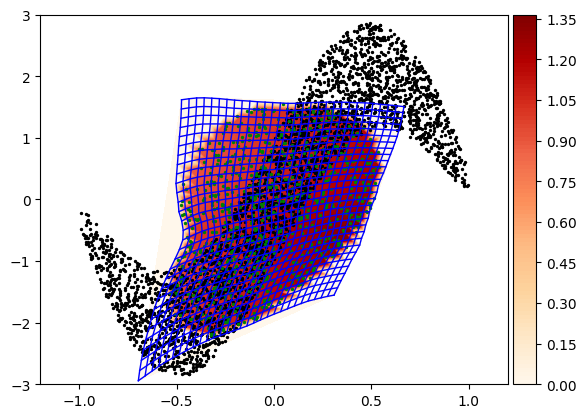

In [252]:
scale=1
factor=1

sampling_data = generate_ellipse(1000, (1, 1))
plot_transformed_grid_and_density(model_wave_2, train_loader, device, sampling_data, grid_width=30,
                                x_range=(-factor, factor), y_range=(-factor, factor), x_lim=(-1.2*scale,1.2*scale), y_lim=(-3*scale,3*scale),
                                density_function=compute_uniform_circle_density)

In [251]:
for cl in model_wave.layers:
    print(cl.s_net[0].weight)

Parameter containing:
tensor([[ 0.3604],
        [-0.4709],
        [-0.7267],
        [ 0.3280],
        [-0.9199],
        [ 0.8730],
        [-0.8875],
        [-0.5853],
        [-0.2529],
        [-0.5477],
        [ 0.1768],
        [ 0.5907],
        [-0.7010],
        [ 0.6873],
        [-0.4899],
        [-0.8358],
        [-0.7537],
        [ 0.4262],
        [-0.5038],
        [ 0.5908],
        [ 0.1622],
        [-0.6357],
        [-0.2436],
        [ 0.1816],
        [ 0.6893],
        [ 0.9726],
        [ 0.8480],
        [-0.6180],
        [ 0.5719],
        [-0.0135],
        [ 0.2554],
        [-0.4826],
        [-0.5188],
        [-0.6131],
        [ 0.0778],
        [-0.8631],
        [-0.6057],
        [ 0.2552],
        [-0.4015],
        [ 0.4889],
        [ 0.2576],
        [ 0.4349],
        [ 0.4926],
        [ 0.8386],
        [ 0.4859],
        [ 0.3419],
        [-0.3720],
        [-0.6613],
        [-0.1397],
        [-0.7909]], device='cuda:0', requires_g

In [239]:
for cl in model_wave_2.layers:
    print(cl.s_net[0].weight)

Parameter containing:
tensor([[ 0.3604],
        [-0.4709],
        [-0.7267],
        [ 0.3280],
        [-0.9199],
        [ 0.8730],
        [-0.8875],
        [-0.5853],
        [-0.2529],
        [-0.5477],
        [ 0.1768],
        [ 0.5907],
        [-0.7010],
        [ 0.6873],
        [-0.4899],
        [-0.8358],
        [-0.7537],
        [ 0.4262],
        [-0.5038],
        [ 0.5908],
        [ 0.1622],
        [-0.6357],
        [-0.2436],
        [ 0.1816],
        [ 0.6893],
        [ 0.9726],
        [ 0.8480],
        [-0.6180],
        [ 0.5719],
        [-0.0135],
        [ 0.2554],
        [-0.4826],
        [-0.5188],
        [-0.6131],
        [ 0.0778],
        [-0.8631],
        [-0.6057],
        [ 0.2552],
        [-0.4015],
        [ 0.4889],
        [ 0.2576],
        [ 0.4349],
        [ 0.4926],
        [ 0.8386],
        [ 0.4859],
        [ 0.3419],
        [-0.3720],
        [-0.6613],
        [-0.1397],
        [-0.7909]], device='cuda:0', requires_g

# Hyperparam Search

In [14]:
# hyperparameter tuning

from hyperopt import hp

space = {'num_couling_layers' : hp.randint('num_couling_layers', 5, 20), #so definiert man das interval (0, 2)      
        'learning_rate' : hp.uniform ('learning_rate', 0.1, 1),
         'momentum' : hp.uniform ('momentum', 0.1, 1.),
         'step_size': hp.choice('step_size', [1,2,3]),
         'gamma' : hp.uniform ('gamma', 0.8, 1),
         'num_epoch' : hp.randint('num_epoch', 3, 50),
         'batch_size_exponent' : hp.randint('batch_size_exponent', 10, 15),
         #'density_param_increment' : hp.uniform ('density_param_increment', 0.1, 1),
         'NN_depth' : hp.choice('NN_depth', [1,2,3,4,5]),   #so kann man über Listen 
         'NN_width' : hp.randint('NN_width', 5, 200),
        }                                                                             #Hyperparamter suchen
#index spaces auch möglich
    # NUM_COUPLING_LAYERS = 10
    # NN_WIDTH = 0
    
    # LEARNING_RATE = 1
    # MOMENTUM = 0.8
    # STEP_SIZE = 1
    # GAMMA = 0.98

    # NUM_EPOCH = 20
    # BATCH_SIZE = 2**space['batch_size_exponent']

# 'batch_size_exponent': [7],
#     'density_param_increment': [0.44412861981816865],
#     'gamma': [0.8180486265222036],
#     'learning_rate': [0.9909497228897849],
#     'momentum': [0.7643280591564052],
#     'num_couling_layers': [10],
#     'num_epoch': [11],
#     'step_size': [1]


# space = {'num_couling_layers' : hp.randint('num_couling_layers', 10, 11), #so definiert man das interval (0, 2)      
#         'learning_rate' : hp.uniform ('learning_rate', 0.9, 1),
#          'momentum' : hp.uniform ('momentum', 0.7, 0.8),
#          'step_size': hp.choice('step_size', [1,2]),
#          'gamma' : hp.uniform ('gamma', 0.8, 1),
#          'num_epoch' : hp.randint('num_epoch', 10, 12),
#          'batch_size_exponent' : hp.randint('batch_size_exponent', 7, 8),
#          'density_param_increment' : hp.uniform ('density_param_increment', 1, 1)
#         #'NN_size' : hp.choice('NN_size', [[16,16],[32,32],[64],[128],[256],[512]]),   #so kann man über Listen 
#         }        

In [18]:
from torch.optim.lr_scheduler import StepLR

from train import training_routine_uniform
from functions import uniform_circle_loss_function

def objective(space):
    """
    Hier die Funktion einfügen, wo die Hyperparamter optimiert werden sollen
    
    Input: space, type: dictionary mit den Hyperparametern
    Output: Der Score/ die Accuracy
    """
    
    #collect all parameters
    NUM_COUPLING_LAYERS = space['num_couling_layers']
    
    LEARNING_RATE = space['learning_rate']
    MOMENTUM = space['momentum']
    STEP_SIZE = space['step_size']
    GAMMA = space['gamma']

    NUM_EPOCH = space['num_epoch']
    BATCH_SIZE = 2**space['batch_size_exponent']

    NN_SIZE = (space['NN_depth'], space['NN_width'])
    
    #DENSITY_PARAM_INCREMENT = space['density_param_increment']

    print(space['batch_size_exponent'])
    

    #make calculations
    
    torch.manual_seed(0)
    model = NN(num_coupling_layers=NUM_COUPLING_LAYERS,layer_size=2, split_size_x1=1, nn_size=NN_SIZE).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
        
    num_epoch = NUM_EPOCH
    batch_size = BATCH_SIZE
    for epoch in range(num_epoch):
        #density_param = (1+DENSITY_PARAM_INCREMENT*epoch, 0.2)
        density_param = (1+10*(epoch+1)/num_epoch, 0.2)
        #print(density_param, epoch, num_epoch)
        training_routine_uniform(model, device, train_loader, optimizer, epoch, batch_size, uniform_circle_loss_function, density_param) 

    
    density_param = (11.,0.2)
    test_score = testing_routine_uniform(model, device, test_loader, batch_size, uniform_circle_loss_function, density_param)
    
    # We aim to maximize accuracy, therefore we return it as a negative value
    # Wenn also etwas maximiert werden soll, schreibe ein - im loss. Sonst lasse das minus weg
    # Man kann sich hier zusätzlich in der action_info Sachen merken.
    return {'loss': test_score, 'status': STATUS_OK}

In [15]:
def objective_method2(space):
    """
    Hier die Funktion einfügen, wo die Hyperparamter optimiert werden sollen
    
    Input: space, type: dictionary mit den Hyperparametern
    Output: Der Score/ die Accuracy
    """
    
    #collect all parameters
    NUM_COUPLING_LAYERS = space['num_couling_layers']
    
    LEARNING_RATE = space['learning_rate']
    MOMENTUM = space['momentum']
    STEP_SIZE = space['step_size']
    GAMMA = space['gamma']

    NUM_EPOCH = space['num_epoch']
    BATCH_SIZE = 2**space['batch_size_exponent']

    NN_SIZE = (space['NN_depth'], space['NN_width'])

    print(space['batch_size_exponent'])
    
    #make calculations
    
    torch.manual_seed(0)
    model = NN(num_coupling_layers=NUM_COUPLING_LAYERS,layer_size=2, split_size_x1=1, nn_size=NN_SIZE).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
    scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)
        
    num_epoch = NUM_EPOCH
    batch_size = BATCH_SIZE
    for epoch in range(num_epoch):
        training_routine(model, device, train_loader, optimizer, epoch, batch_size, uniform_circle_loss_function_method2) 

    test_score = testing_routine(model, device, test_loader, batch_size, uniform_circle_loss_function_method2)

    #
    # accuracy = test_score #calculate some kind of score/ accuracy 

    # #normalisiere am besten die Accuracy! (so dass es im (0,1) intervall ist)
    # accuracy = accuracy
    
    # We aim to maximize accuracy, therefore we return it as a negative value
    # Wenn also etwas maximiert werden soll, schreibe ein - im loss. Sonst lasse das minus weg
    # Man kann sich hier zusätzlich in der action_info Sachen merken.
    return {'loss': test_score, 'status': STATUS_OK}

In [16]:
import pickle
import os 
file_name = "acl2.hyperopt"

def run_trials(trials_step=1):
    #functions that runs the trials
    
    trials_step = trials_step  # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = 3  # initial max_trials. put something small to not have to wait
    
    try:  # try to load already saved trials
        trials = pickle.load(open(file_name, "rb"))
        print("Found saved Trials! Loading...")
        
        max_trials = len(trials.trials) + trials_step   #increase amount of maximal trials
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, trials_step))
    except:  # create a new trials object and start searching
        print("Creating new Trial")
        trials = Trials()

    best = fmin(fn = objective_method2,   #function über die optimiert wird
            space = space,        #hyperparameter space
            algo = tpe.suggest,   #Algorithmus für Hyperparameter Suche
            max_evals = max_trials,  #wie viel trainieren
            trials = trials)        #nutze alte trials

    print("Run:", best)    #die besten hyperparameter werden hier geprinted

    #print(trials.trials)
    with open(file_name, "wb") as f:
        pickle.dump(trials, f)

In [18]:
%%time
#hier können wir jetzt die trials laufen lassen
for k in range(1):
    run_trials(10)

Found saved Trials! Loading...
Rerunning from 3 trials to 13 (+10) trials
11                                                                                                                     
13                                                                                                                     
14                                                                                                                     
11                                                                                                                     
11                                                                                                                     
10                                                                                                                     
11                                                                                                                     
12                                                                                    

In [19]:
trials = pickle.load(open(file_name, "rb"))
# results = [(t['result']['loss'], t['misc']['vals']['learning_rate'], t['misc']['vals']['noise_std']) for t in trials.trials]
# df = pd.DataFrame(results, columns=['loss', 'lr', 'noise_std'])
# #df.iloc[np.argmin(df['loss'])]
# df
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': -16827.203125, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'NN_depth': [0],
    'NN_width': [0],
    'batch_size_exponent': [0],
    'gamma': [0],
    'learning_rate': [0],
    'momentum': [0],
    'num_couling_layers': [0],
    'num_epoch': [0],
    'step_size': [0]},
   'vals': {'NN_depth': [1],
    'NN_width': [69],
    'batch_size_exponent': [10],
    'gamma': [0.872909742777875],
    'learning_rate': [0.1443378257116975],
    'momentum': [0.9340286470573611],
    'num_couling_layers': [15],
    'num_epoch': [13],
    'step_size': [2]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2024, 3, 12, 13, 1, 35, 292000),
  'refresh_time': datetime.datetime(2024, 3, 12, 13, 2, 33, 310000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 0.0, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domai

In [85]:
# MISTAKE 2024-03-05: CHOOSE RIGHT LOSS_FUNCTION FOR TESTING. OTHERWISE NaN and inf VALUES BECOME COMMON!

# Todo: True loss function (Done)
# NN structure to params (Done)

# ACL and LU-Net hyperparam search 
# grid distortion term + hyperparam search 
 
# More complicated shapes
# 3D shapes

# Video by parameter interpolation

In [12]:
from visuals import plot_generating_uniform_density, compute_uniform_circle_density


tensor([inf, inf, inf,  ..., inf, inf, inf], device='cuda:0') tensor([inf, inf, inf,  ..., inf, inf, inf], device='cuda:0') tensor([2.3744, 2.3682, 2.3646,  ..., 2.3352, 2.3344, 2.3336], device='cuda:0')


D:\master-thesis\acl\visuals.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(sampling_data, dtype=torch.float32).to(device), reverse=True)


0

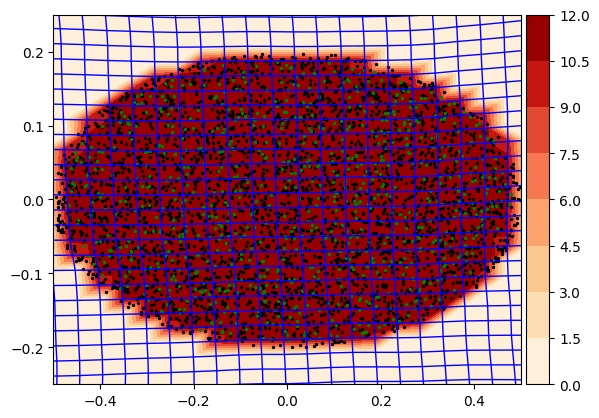

In [13]:
sampling_data = generate_ellipse(1000, (1, 1))

range_param = 1.5

density_param = (100,0.02)

plot_generating_uniform_density(testNN, device, density_param, train_loader, sampling_data, grid_width=30,
                                x_range=(-range_param, range_param), y_range=(-range_param, range_param), x_lim=(-0.5,0.5), y_lim=(-0.25,0.25),
                                density_function=compute_uniform_circle_density)

# Training with Gaussian Density

In [78]:
torch.manual_seed(0)

testNN = NN(num_coupling_layers=30,layer_size=2, split_size_x1=1, nn_size=(1,100)).to(device)
testNN

NN(
  (layers): ModuleList(
    (0-29): 30 x CouplingLayer(
      (t_net): ModuleList(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): Linear(in_features=100, out_features=100, bias=True)
        (2): Linear(in_features=100, out_features=1, bias=True)
      )
      (s_net): ModuleList(
        (0): Linear(in_features=1, out_features=100, bias=True)
        (1): Linear(in_features=100, out_features=100, bias=True)
        (2): Linear(in_features=100, out_features=1, bias=True)
      )
      (activation): ReLU()
    )
  )
)

In [79]:
from torch.optim.lr_scheduler import StepLR

optimizer = torch.optim.SGD(testNN.parameters(), lr=1, momentum=0.8)
scheduler = StepLR(optimizer, step_size=1, gamma=0.98)

In [80]:
from train import training_routine
from functions import gaussian_loss_function

In [81]:
%%time

num_epoch = 20
batch_size = 1024
for epoch in range(num_epoch):
    training_routine(testNN, device, train_loader, optimizer, epoch, batch_size, gaussian_loss_function) 

CPU times: total: 3min 4s
Wall time: 3min 5s


In [48]:
from visuals import plot_generating_gaussian_density, compute_gaussian_density


In [82]:
sampling_data = torch.normal(torch.zeros(1000,2), torch.ones(1000,2))
sampling_data

tensor([[-0.3505,  0.4639],
        [ 0.1060,  0.6005],
        [ 0.1557, -0.8488],
        ...,
        [-0.9496,  1.7330],
        [-1.2764,  0.4050],
        [ 0.3496, -0.0547]])

torch.Size([1800]) torch.Size([1800, 10])
tensor([3.3113, 2.7487, 2.2337,  ..., 3.5337, 3.9046, 4.3247], device='cuda:0') tensor(1.1447, dtype=torch.float64) tensor([9.0000, 8.4007, 7.8442,  ..., 7.8442, 8.4007, 9.0000], device='cuda:0') tensor([6.8334, 6.7967, 6.7552,  ..., 5.4552, 5.6408, 5.8201], device='cuda:0')


0

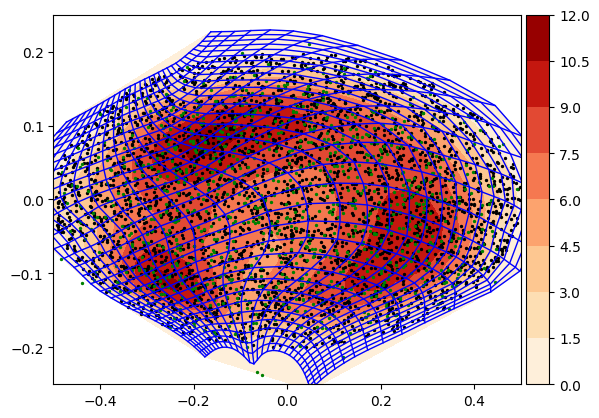

In [77]:
plot_generating_gaussian_density(testNN, device, density_param, train_loader, sampling_data.detach(), grid_width=30,
                                x_range=(-3, 3), y_range=(-3, 3), x_lim=(-0.5,0.5), y_lim=(-0.25,0.25))